In [1]:
import pandas as pd

In [5]:
excel_file = pd.ExcelFile('C:/Users/Acer/Downloads/用电数据 (2).xlsx')

# 获取指定工作表中的数据，设置表头行为1
df = excel_file.parse('趋势曲线-2025-06-01 000000-2025-07-', header=1)

In [6]:
df.head()

,时间,正向有功电能,A相电流,B相电流,C相电流,A相有功功率,B相有功功率,C相有功功率,视在功率
0,2025-06-01 00:00:00,9215940.0,426.24,445.57,561.91,95.46,99.93,126.97,330.36
1,2025-06-01 01:00:00,9216270.0,393.85,447.48,535.16,88.51,100.62,121.57,320.59
2,2025-06-01 02:00:00,9216579.0,373.90,419.10,519.39,84.60,95.11,118.83,306.91
3,2025-06-01 03:00:00,9216908.0,423.06,480.36,601.83,94.36,107.21,135.10,353.00
4,2025-06-01 04:00:00,9217232.0,390.27,463.63,555.34,87.63,104.43,125.72,331.83


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间      590 non-null    object 
 1   正向有功电能  589 non-null    float64
 2   A相电流    588 non-null    float64
 3   B相电流    589 non-null    float64
 4   C相电流    588 non-null    float64
 5   A相有功功率  588 non-null    float64
 6   B相有功功率  588 non-null    float64
 7   C相有功功率  588 non-null    float64
 8   视在功率    589 non-null    float64
dtypes: float64(8), object(1)
memory usage: 41.6+ KB


## 数据预处理

In [8]:
missing_values = df.isnull().sum()
print("每列的缺失值数量：")
print(missing_values)

每列的缺失值数量：
时间        0
正向有功电能    1
A相电流      2
B相电流      1
C相电流      2
A相有功功率    2
B相有功功率    2
C相有功功率    2
视在功率      1
dtype: int64


### 1.删除空值

In [10]:
# 删除含有缺失值的行
df = df.dropna()

# 将结果保存为新的 Excel 文件
new_file_path = 'C:/lsx/用电数据 (2)_删除缺失值.xlsx'
df.to_excel(new_file_path, index=False)

### 2.检验一下是否有异常值

In [12]:
# 创建一个空的 DataFrame 用于存储异常值
outliers = pd.DataFrame()

# 筛选出数值型列
numeric_columns = df.select_dtypes(include='number').columns

# 遍历每个数值型列
for col in numeric_columns:
    # 计算下四分位数和上四分位数
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # 计算四分位距
    IQR = Q3 - Q1

    # 计算异常值的上下边界
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 筛选出异常值
    col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # 将异常值添加到 outliers DataFrame 中
    outliers = pd.concat([outliers, col_outliers], axis=0)

# 去除重复的行
outliers = outliers.drop_duplicates()

# 查看异常值数据
outliers

#空值，说明没有异常值

,时间,正向有功电能,A相电流,B相电流,C相电流,A相有功功率,B相有功功率,C相有功功率,视在功率


### 3.将时间列转换为日期时间类型 为后续计算做准备

In [17]:
df['时间'] = pd.to_datetime(df['时间'])

In [14]:
import matplotlib.pyplot as plt

In [16]:
df

,时间,正向有功电能,A相电流,B相电流,C相电流,A相有功功率,B相有功功率,C相有功功率,视在功率
0,2025-06-01 00:00:00,9215940.0,426.24,445.57,561.91,95.46,99.93,126.97,330.36
1,2025-06-01 01:00:00,9216270.0,393.85,447.48,535.16,88.51,100.62,121.57,320.59
2,2025-06-01 02:00:00,9216579.0,373.90,419.10,519.39,84.60,95.11,118.83,306.91
3,2025-06-01 03:00:00,9216908.0,423.06,480.36,601.83,94.36,107.21,135.10,353.00
4,2025-06-01 04:00:00,9217232.0,390.27,463.63,555.34,87.63,104.43,125.72,331.83
...,...,...,...,...,...,...,...,...,...
584,2025-06-25 08:00:00,9489604.0,680.84,855.91,1018.56,153.44,193.48,230.66,588.29
585,2025-06-25 09:00:00,9490241.0,709.35,907.82,1071.35,162.00,206.42,245.00,621.65
586,2025-06-25 10:00:00,9490869.0,717.20,873.18,1037.66,162.78,196.99,235.56,603.22
588,2025-06-25 12:00:00,9492159.0,799.83,947.09,1168.50,182.06,213.68,260.33,666.94


## 数据分析

### 1. 计算负载率，标记出重载时段

In [18]:

df['负载率'] = df['视在功率'] / 1250 * 100
df['是否重载'] = df['负载率'] > 80

# 按日期和是否重载进行分组统计重载次数
daily_overload = df.groupby(df['时间'].dt.date)['是否重载'].sum()
most_overload_date = daily_overload.idxmax()

### 2. 计算每天的用电量，找出用电量最大和最小的时段

In [19]:
df['日期'] = df['时间'].dt.date
daily_consumption = df.groupby('日期').agg({'正向有功电能': lambda x: x.iloc[-1] - x.iloc[0]})
max_consumption_date = daily_consumption['正向有功电能'].idxmax()
min_consumption_date = daily_consumption['正向有功电能'].idxmin()

print(f'重载次数最多的日期是：{most_overload_date}')
print(f'用电量最大的日期是：{max_consumption_date}，用电量为：{daily_consumption.loc[max_consumption_date, "正向有功电能"]}')
print(f'用电量最小的日期是：{min_consumption_date}，用电量为：{daily_consumption.loc[min_consumption_date, "正向有功电能"]}')


重载次数最多的日期是：2025-06-01
用电量最大的日期是：2025-06-10，用电量为：11850.0
用电量最小的日期是：2025-06-25，用电量为：6215.0


In [23]:
plt.rcParams['figure.dpi'] = 300

plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

## 数据可视化

### 1.绘制负载率随时间变化图

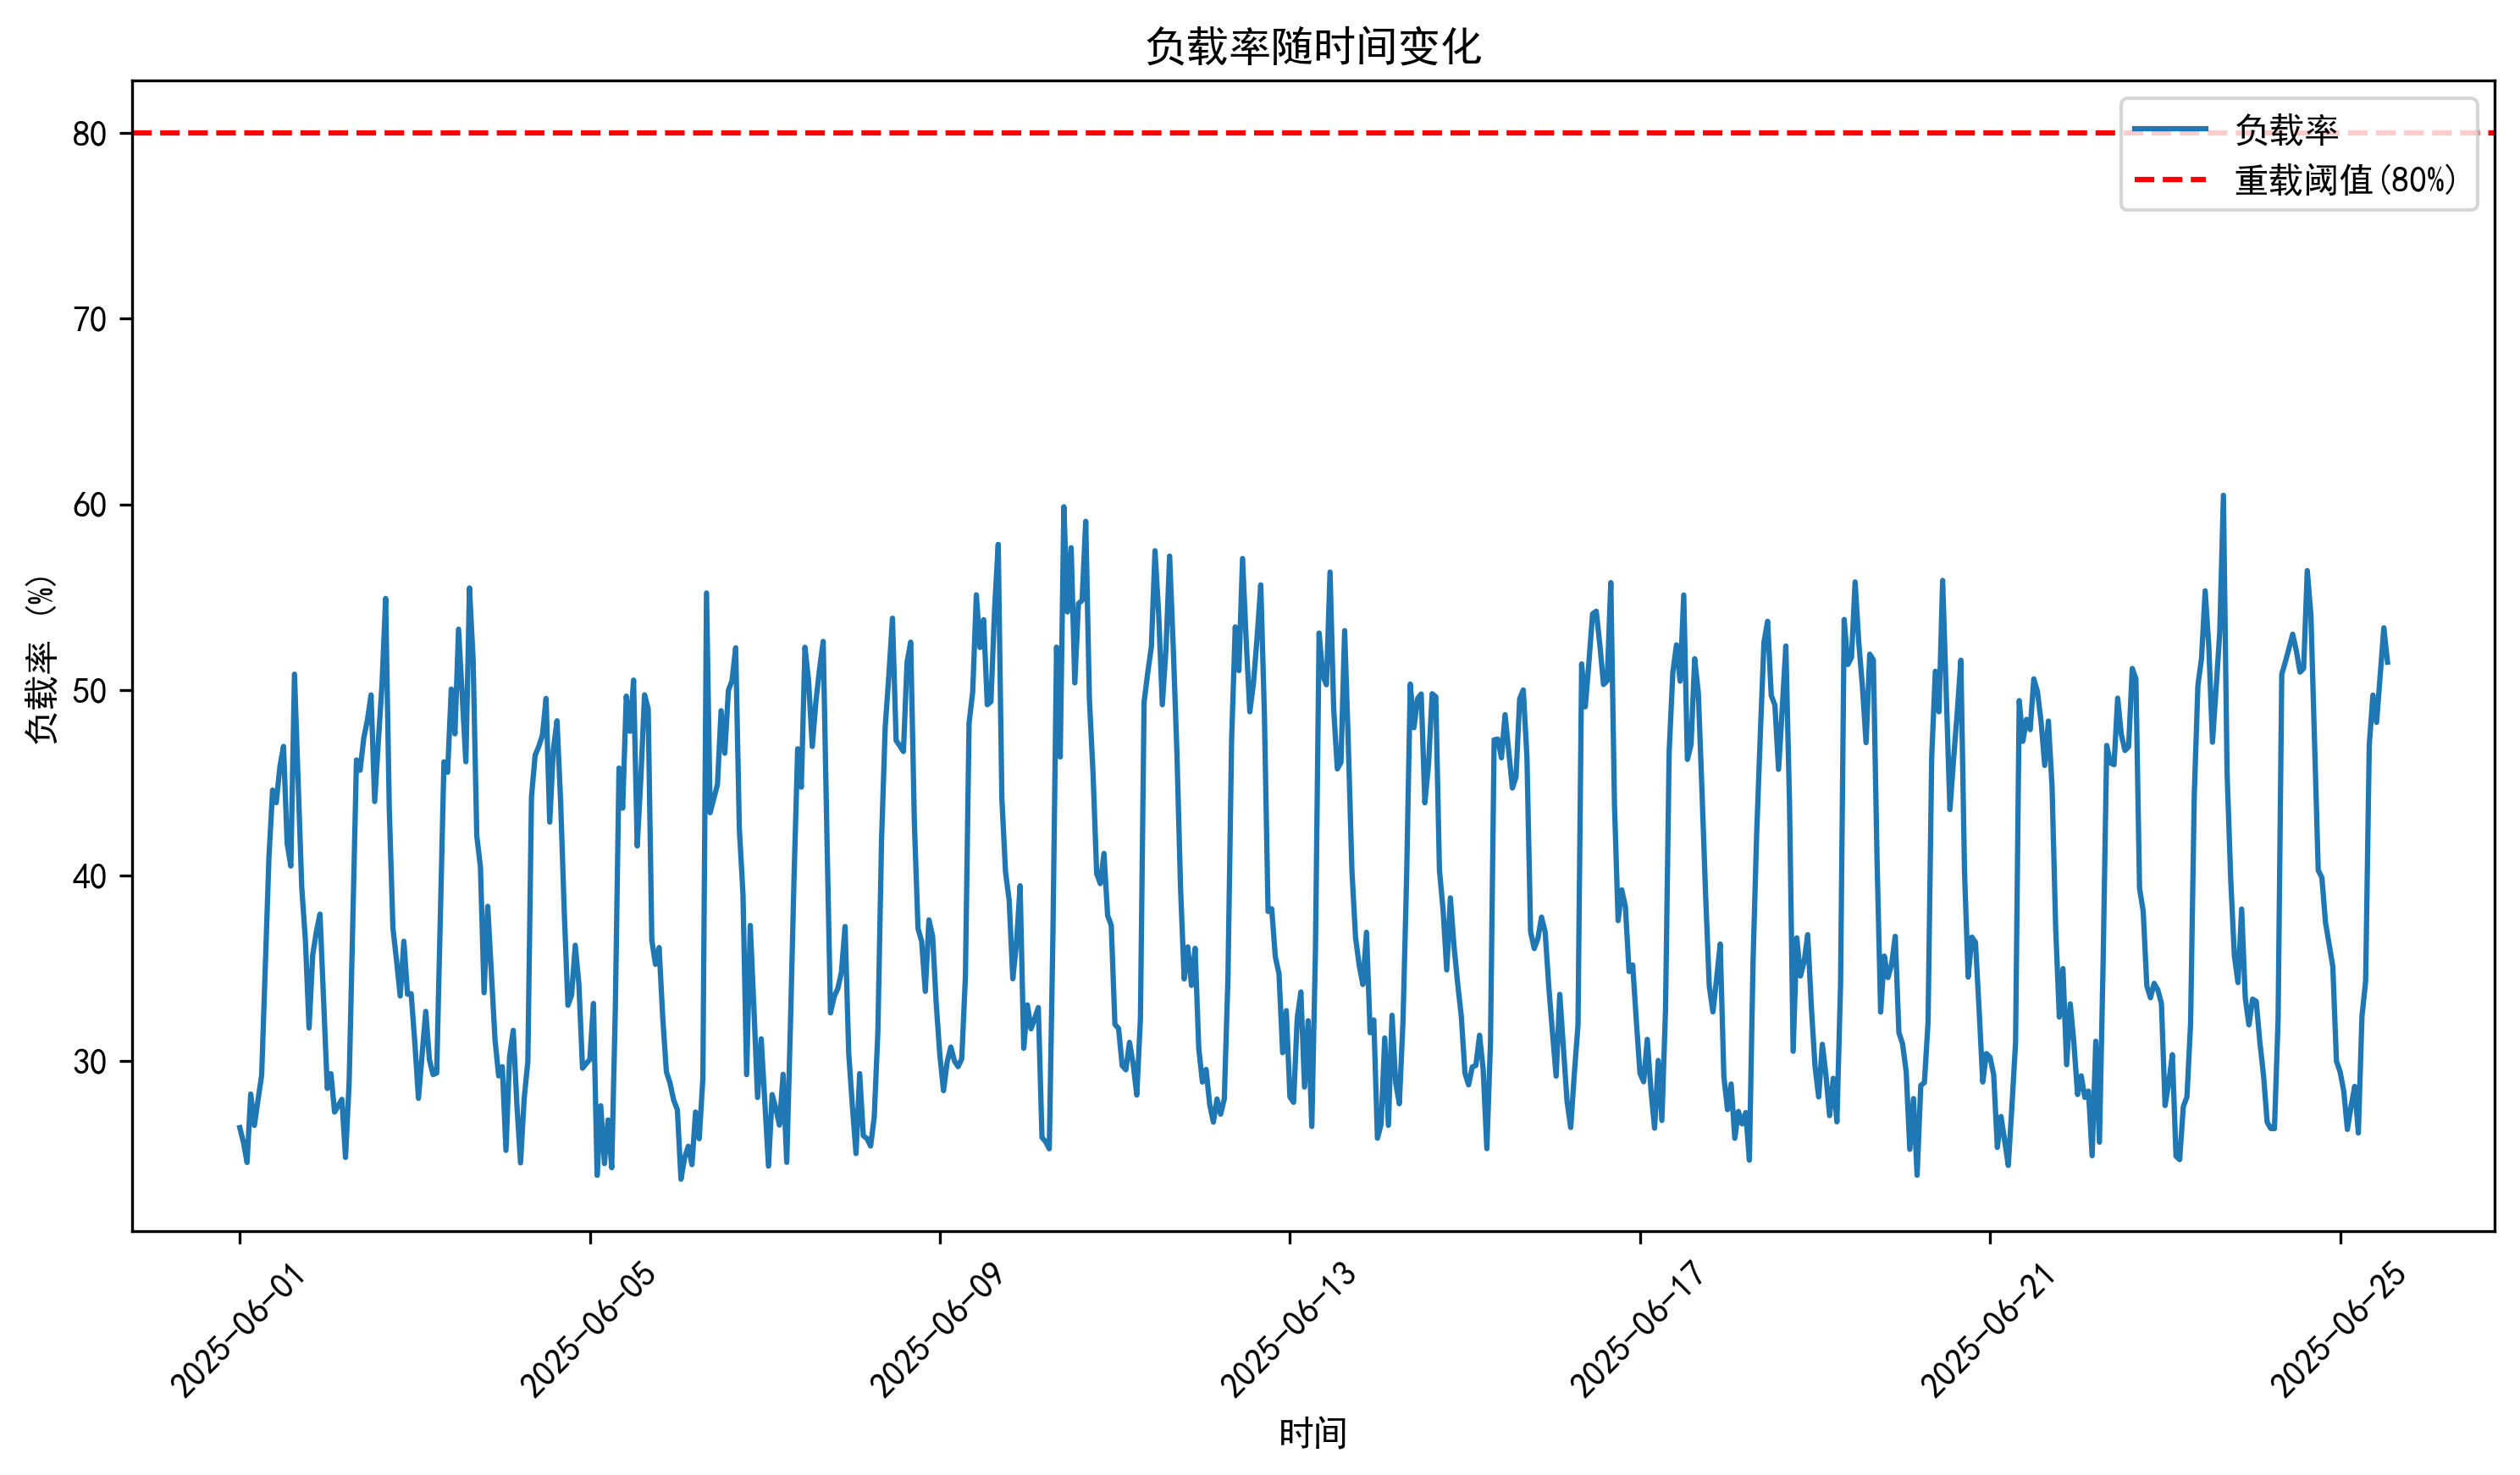

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(df['时间'], df['负载率'], label='负载率')
plt.axhline(y=80, color='r', linestyle='--', label='重载阈值(80%)')
plt.xlabel('时间')
plt.xticks(rotation=45)
plt.ylabel('负载率 (%)')
plt.title('负载率随时间变化')
plt.legend()
plt.show()

### 分析结果：重载高发时段
#### 1.可能发生重载的时段：工作日的 8:00-18:00（核心为 10:00-15:00），需在此期间重点监控视在功率和负载率，确保设备运行安全。
#### 2.优化建议：可通过错峰用电、负载均衡（如调整三相电流分配，减少 C 相过载压力）等方式，降低日间高峰时段的负载率，避免设备长期接近重载阈值运行。

### 2.绘制每天用电量柱状图

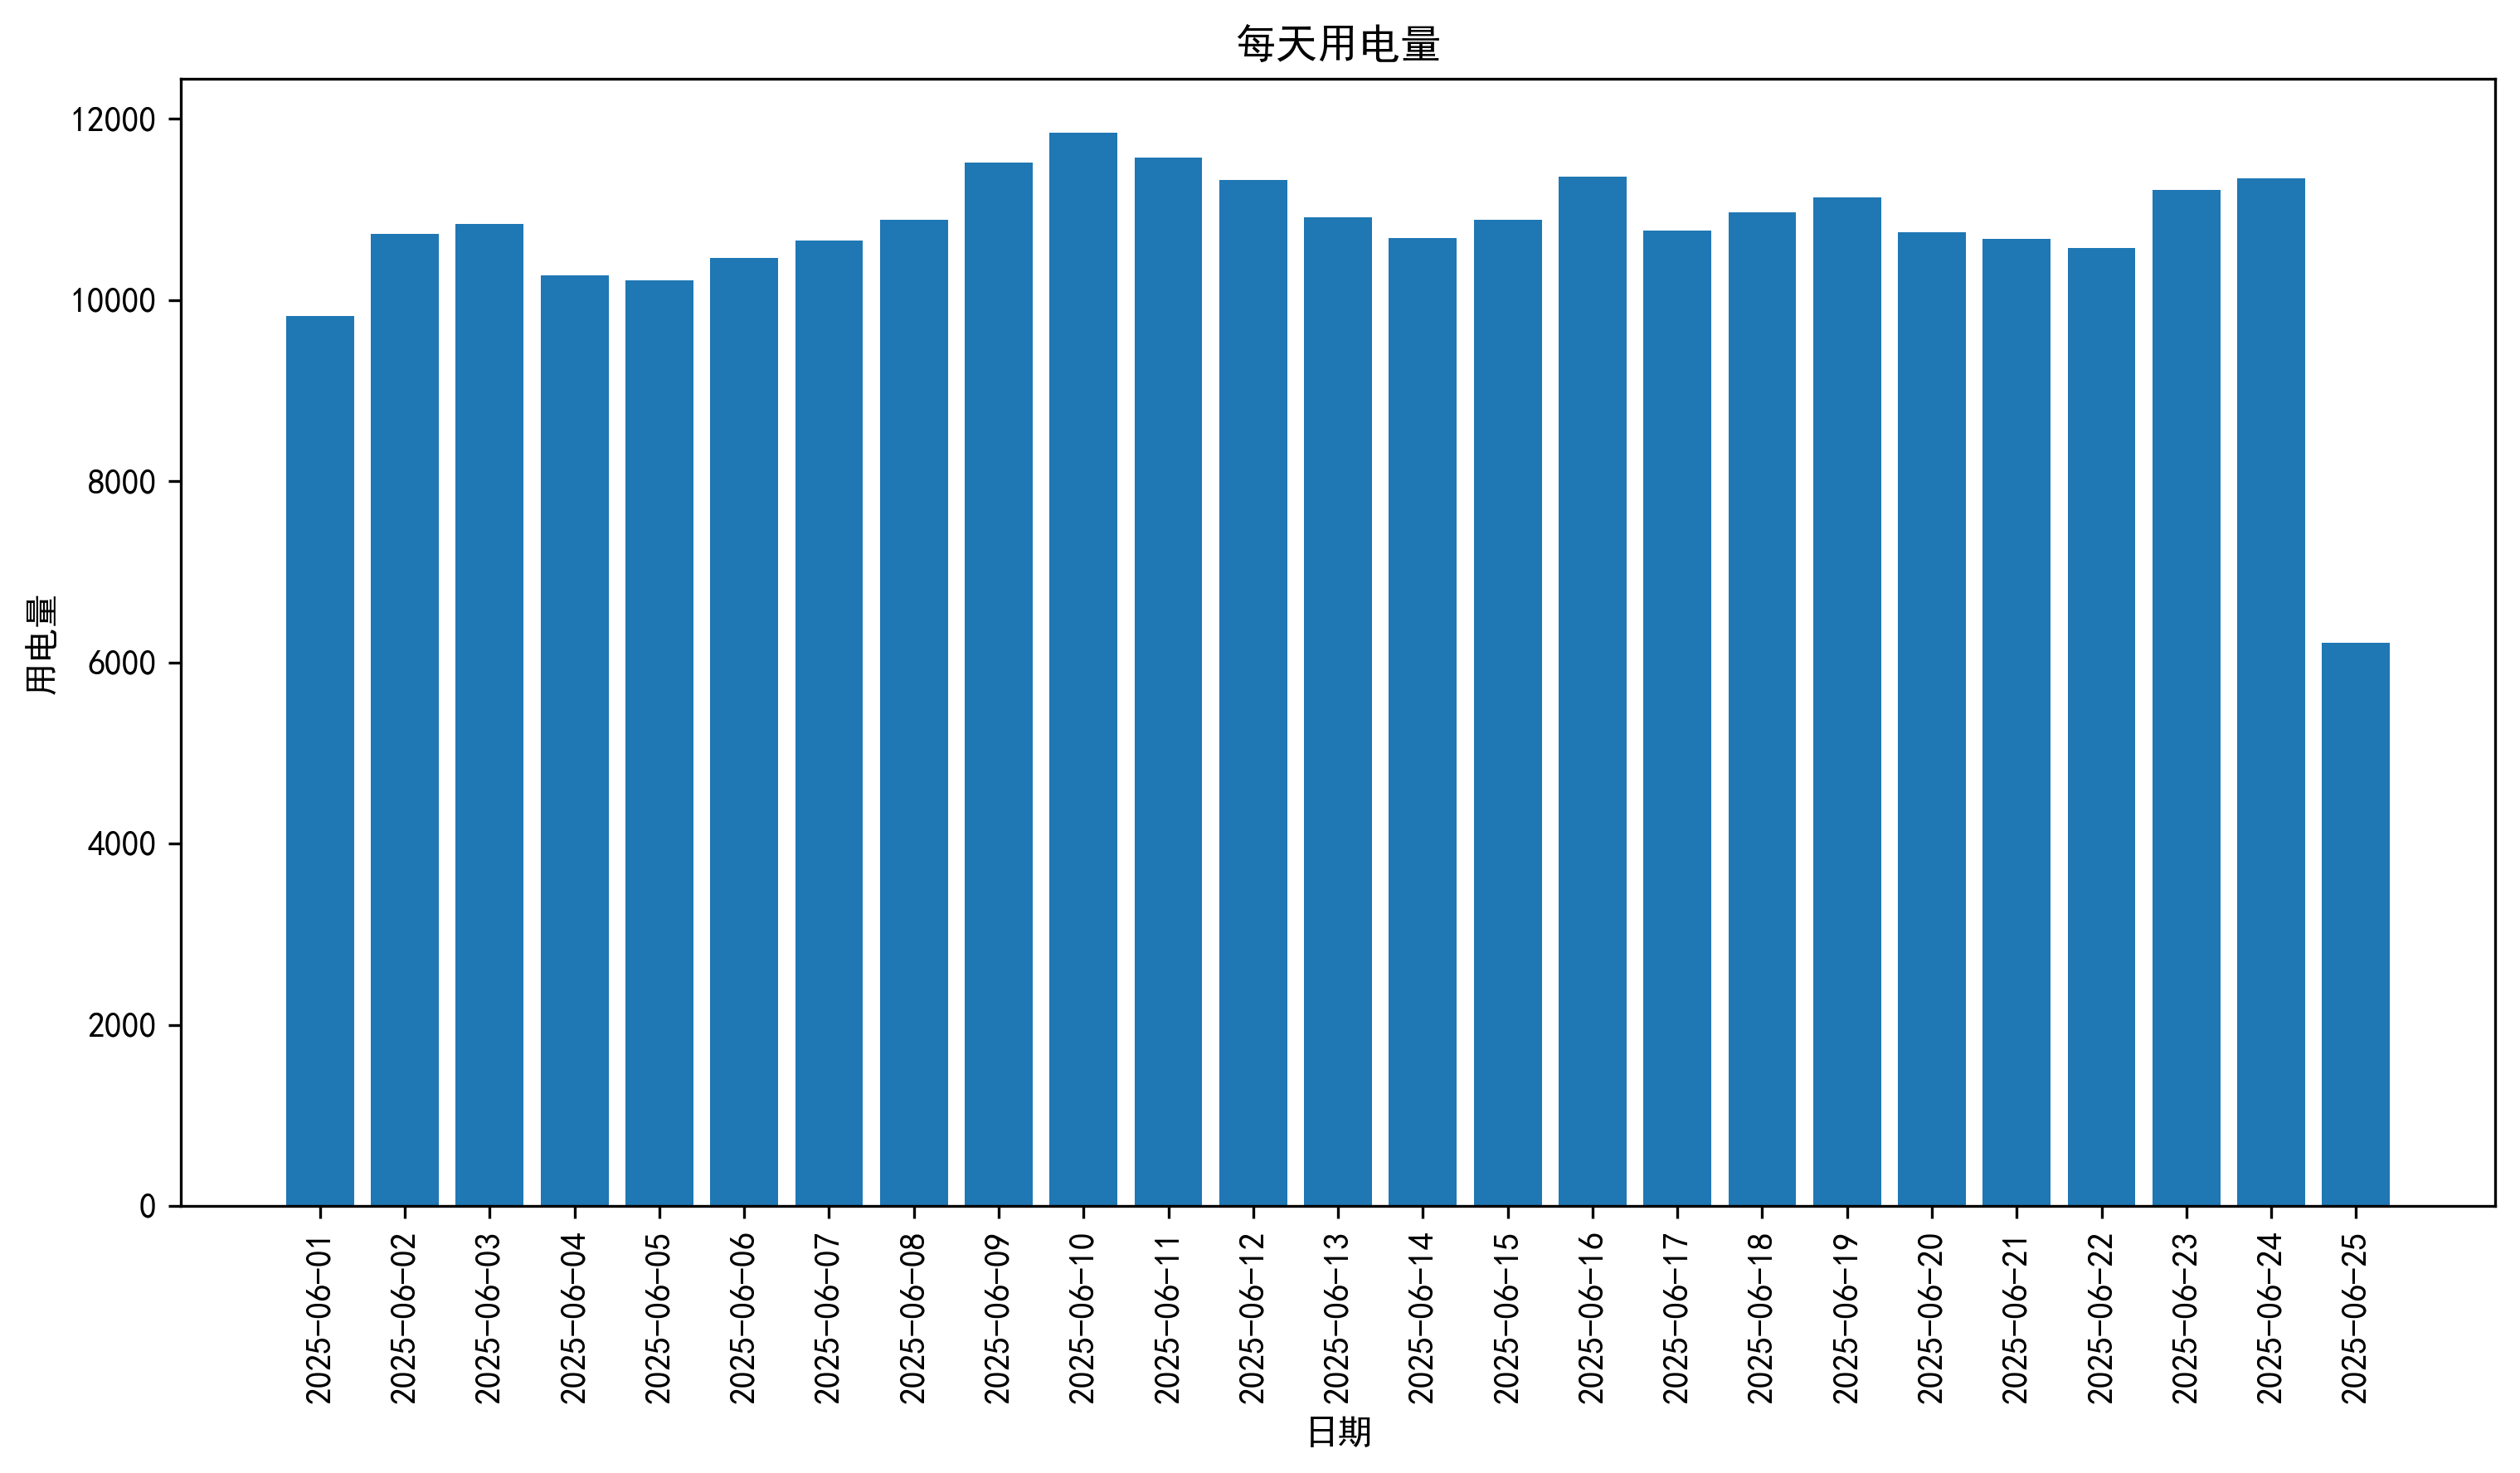

In [27]:
plt.figure(figsize=(12, 6))
plt.bar(daily_consumption.index.astype(str), daily_consumption['正向有功电能'])
plt.xlabel('日期')
plt.ylabel('用电量')
plt.title('每天用电量')
plt.xticks(rotation=90)
plt.show()

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### 3.绘制电能与功率趋势图

In [43]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=df['时间'], 
    y=df['正向有功电能'], 
    name='正向有功电能', 
    line=dict(color='blue')
))

fig1.add_trace(go.Scatter(
    x=df['时间'], 
    y=df['视在功率'], 
    name='视在功率', 
    line=dict(color='green'),
    yaxis='y2'
))

fig1.update_layout(
    title="电能与功率趋势",
    xaxis_title="时间",
    yaxis=dict(
        title="kWh",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="kVA",
        titlefont=dict(color="green"),
        tickfont=dict(color="green"),
        anchor="free",
        overlaying="y",
        side="right",
        position=1.0
    ),
    height=400
)

fig1.show()

### 分析结果：电能与功率趋势分析

#### 1.正向有功电能呈持续累积增长 

正向有功电能作为总用电量的累积指标，从 6 月 1 日的 9215940 kWh 稳步增长至 6 月 25 日的 9492825 kWh，整体呈线性上升趋势，反映这段时间内总用电量的持续增加。

#### 2.视在功率日内波动规律显著

视在功率（即时用电负荷）呈现明显的日内峰谷特征：
高峰时段集中在每日 8:00-18:00，峰值多出现于 10:00-15:00（如 6 月 10 日 10 时达 748.44 kVA），与日间生产或活动用电需求旺盛一致；
低谷时段为每日 0:00-6:00，谷值多低于 400 kVA（如 6 月 5 日 2 时仅 298.23 kVA），符合深夜用电活动减少的规律，体现用电行为对时间的高度依赖。

#### 3.功率与电能的关联性

视在功率的高峰时段对应正向有功电能的快速增长（每小时增量大），低谷时段对应电能增量放缓，说明即时功率波动直接影响总用电量的累积速度。

### 4.绘制三相电流趋势图

In [41]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df['时间'], 
    y=df['A相电流'], 
    name='A相电流', 
    line=dict(color='red')
))

fig2.add_trace(go.Scatter(
    x=df['时间'], 
    y=df['B相电流'], 
    name='B相电流', 
    line=dict(color='orange')
))

fig2.add_trace(go.Scatter(
    x=df['时间'], 
    y=df['C相电流'], 
    name='C相电流', 
    line=dict(color='purple')
))

fig2.update_layout(
    title="三相电流趋势",
    xaxis_title="时间",
    yaxis_title="A",
    height=400
)

fig2.show()

### 三相电流特性分析
#### 1.三相负载不平衡特征明显
C 相电流持续高于 A、B 相，多数时段为负载最重的相位（如 6 月 1 日 0 时 C 相 561.91 A，A 相 426.24 A，B 相 445.57 A；6 月 10 日 10 时 C 相 1245.25 A，A 相 900.37 A，B 相 1073.52 A）；
A 相和 B 相电流相对接近，整体负载轻于 C 相，反映三相用电分配存在差异。
#### 2.三相电流波动与功率同步
三相电流的日内变化趋势与视在功率高度一致：日间高峰时段（8:00-18:00）三相电流同步上升，深夜低谷时段同步下降，说明各相电流随整体用电负荷的增减而协同变化，电流波动是功率波动的直接体现。

In [34]:
# 取最后一条数据作为实时数据
last = df.iloc[-1]

# 仪表盘布局
dashboard = go.Figure()

# 负载率（gauge）
dashboard.add_trace(go.Indicator(
    mode="gauge+number",
    value=last['视在功率'] / 1250 * 100,  # 负载率计算
    title={"text": "负载率"},
    gauge={
        "axis": {"range": [0, 100]},
        "bar": {"color": "blue"},
        "steps": [
            {"range": [0, 80], "color": "lightgray"},
            {"range": [80, 100], "color": "red"}  # 重载警示
        ]
    },
    domain={'x': [0, 0.45], 'y': [0, 1]}
))

# 功率卡片（视在功率 + 有功功率）
dashboard.add_trace(go.Indicator(
    mode="number+delta",
    value=last['视在功率'],
    title={"text": "视在功率 (kVA)"},
    delta={"reference": df.iloc[-2]['视在功率'] if len(df)>1 else last['视在功率'], "valueformat": ".2f"},
    domain={'x': [0.55, 1], 'y': [0, 0.5]}
))
dashboard.add_trace(go.Indicator(
    mode="number+delta",
    value=last['正向有功电能'],
    title={"text": "正向有功电能 (kWh)"},
    delta={"reference": df.iloc[-2]['正向有功电能'] if len(df)>1 else last['正向有功电能'], "valueformat": ".2f"},
    domain={'x': [0.55, 1], 'y': [0.5, 1]}
))

# 布局优化
dashboard.update_layout(
    grid={'rows': 2, 'columns': 2, 'pattern': "independent"},
    title_text="实时用电数据监控"
)
dashboard.show()